# Transfer Learning With TensorFlow Part3: Scaling Up
> FOOD VISION MINI

In [ ]:
!nvidia-smi

Mon Nov  6 06:56:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-26 13:35:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-26 13:35:11 (99.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


--2023-11-06 07:01:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   152MB/s    in 14s     

2023-11-06 07:02:10 (113 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_cla

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size=IMG_SIZE
)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
data_aug_model = tf.keras.models.Sequential(
   [ tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),]
)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_aug_model(inputs)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

hist_1 = model_1.fit(train_data_all_10_percent,
                     epochs=5,
                     validation_data=test_data_all_10_percent,
                     validation_steps=int(0.14* len(train_data_all_10_percent)),
                     callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 114s 418ms/step - loss: 3.3616 - accuracy: 0.2789 - val_loss: 2.5407 - val_accuracy: 0.4716
Epoch 2/5
237/237 [==============================] - 73s 306ms/step - loss: 2.1905 - accuracy: 0.5013 - val_loss: 2.0363 - val_accuracy: 0.5237
Epoch 3/5
237/237 [==============================] - 64s 267ms/step - loss: 1.8207 - accuracy: 0.5662 - val_loss: 1.9710 - val_accuracy: 0.5142
Epoch 4/5
237/237 [==============================] - 56s 232ms/step - loss: 1.6051 - accuracy: 0.6102 - val_loss: 1.9086 - val_accuracy: 0.5180
Epoch 5/5
237/237 [==============================] - 51s 214ms/step - loss: 1.4432 - accuracy: 0.6459 - val_loss: 1.8430 - val_accuracy: 0.5246


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

In [ ]:
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d_1/Mean:0', description="created by layer 'global_average_pooling2d_1'")


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
for i in model_1.layers:
  print(i.name, i.trainable)

input_layer True
sequential_1 True
efficientnetb0 True
global_average_pooling2d_1 True
output_layer True


In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
hist_2 = model_1.fit(train_data_all_10_percent,
                     epochs=10,
                     validation_data=test_data_all_10_percent,
                     validation_steps=int(0.14* len(train_data_all_10_percent)),
                     initial_epoch=5,
                     callbacks=[checkpoint_callback])

Epoch 6/10
237/237 [==============================] - 64s 223ms/step - loss: 1.2206 - accuracy: 0.6838 - val_loss: 1.9518 - val_accuracy: 0.4943
Epoch 7/10
237/237 [==============================] - 49s 201ms/step - loss: 1.0978 - accuracy: 0.7053 - val_loss: 1.9636 - val_accuracy: 0.4962
Epoch 8/10
237/237 [==============================] - 44s 186ms/step - loss: 1.0235 - accuracy: 0.7284 - val_loss: 1.9508 - val_accuracy: 0.4981
Epoch 9/10
237/237 [==============================] - 44s 184ms/step - loss: 0.9324 - accuracy: 0.7492 - val_loss: 1.9588 - val_accuracy: 0.5038
Epoch 10/10
237/237 [==============================] - 41s 170ms/step - loss: 0.9040 - accuracy: 0.7603 - val_loss: 1.9726 - val_accuracy: 0.5009


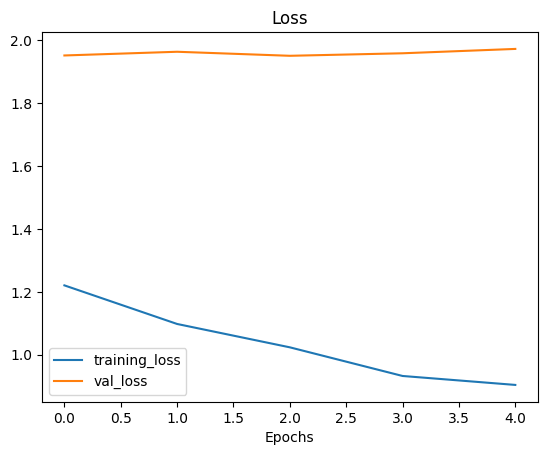

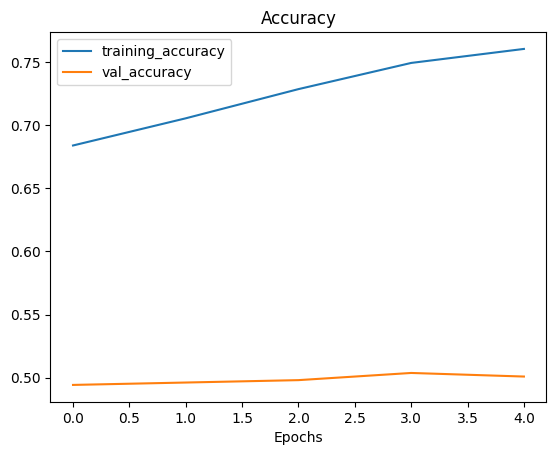

In [ ]:
plot_loss_curves(hist_2)

In [ ]:
model_1.save('drive/MyDrive/101FoodVision_10%')

In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/101FoodVision_10%')

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 80s 98ms/step - loss: 1.4997 - accuracy: 0.6013


In [ ]:
model_1.evaluate(test_data_all_10_percent)

790/790 [==============================] - 67s 84ms/step - loss: 1.4997 - accuracy: 0.6013


[1.4997375011444092, 0.6013465523719788]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-11-06 09:18:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 173.194.206.207, 209.85.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   187MB/s    in 0.2s    

2023-11-06 09:18:04 (187 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [ ]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 65s 78ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [ ]:
preds_probs = model.predict(test_data_all_10_percent,verbose=1)

790/790 [==============================] - 68s 83ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
pred_classses = preds_probs.argmax(axis=1)

In [ ]:
y_labels = []
for imgs, labels in test_data_all_10_percent.unbatch():
  # print(labels.numpy().argmax())
  # break
  y_labels.append(labels.numpy().argmax())

In [ ]:
y_labels[:5]

[0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_labels,pred_classses)

0.6077623762376237

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels,
                      pred_classses,
                      test_data_all_10_percent.class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True
                      )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(y_labels,pred_classses))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
test_data_all_10_percent.class_names[88]

NameError: ignored